# КУРСОВА РОБОТА
### з дисципліни «Методи та технології напівкерованого навчання»
### на тему: «**Класифікація гіперспектральних зображень на основі напівкерованого навчання згорткової мережі та адаптивного зменшення розмірності**»


Original paper: "Hyperspectral Imagery Classification based on Semi-Supervised 3-D Deep Neural Network and Adaptive Band Selection" 

#### 1. Налаштування середовища

In [1]:
import torch
import numpy as np
import random
import os

def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### 2. Обробка набору даних

In [4]:
import os
import numpy as np
import urllib.request
import scipy.io
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import torch

def download_indian_pines(data_dir="data/indian_pines_data"):
    os.makedirs(data_dir, exist_ok=True)
    urls = {
        "indian_pines_corrected.mat": "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat",
        "indian_pines_gt.mat": "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat"
    }
    for fname, url in urls.items():
        path = os.path.join(data_dir, fname)
        if not os.path.exists(path):
            print(f"Downloading {fname}...")
            urllib.request.urlretrieve(url, path)
    return data_dir

def load_indian_pines(data_dir):
    data = scipy.io.loadmat(os.path.join(data_dir, 'indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = scipy.io.loadmat(os.path.join(data_dir, 'indian_pines_gt.mat'))['indian_pines_gt']

    h, w, b = data.shape
    data = data.reshape(-1, b)
    data = MinMaxScaler().fit_transform(data).reshape(h, w, b)

    # labels = LabelEncoder().fit_transform(labels.flatten()).reshape(h, w)
    return data, labels

data_dir = download_indian_pines()
data, labels = load_indian_pines(data_dir)

In [5]:
data.shape

(145, 145, 200)

Examples of bandes


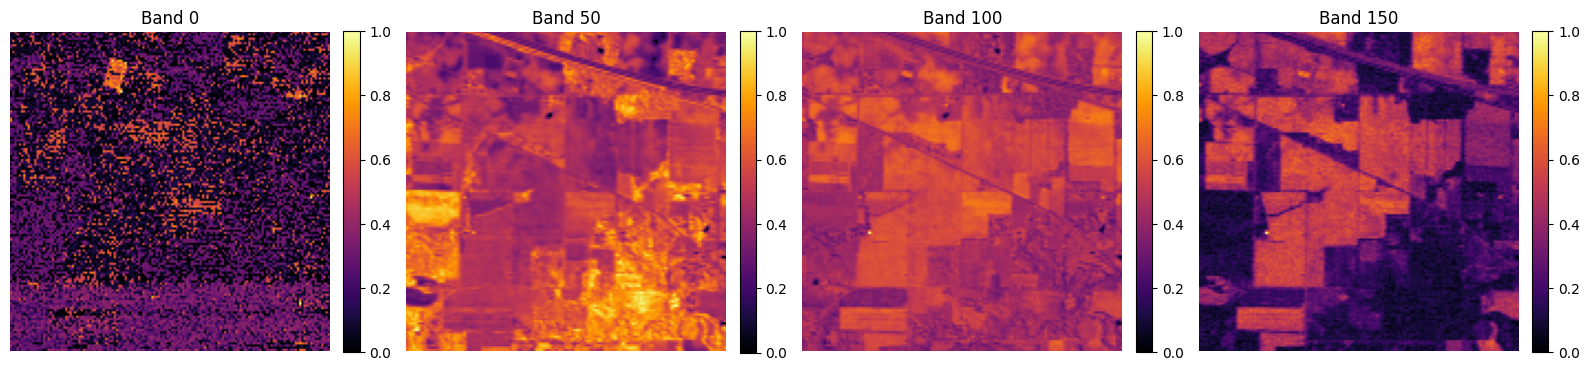

In [6]:
import matplotlib.pyplot as plt

print('Examples of bandes')
fig, axes = plt.subplots(1, 4, figsize=(16, 10))
axes = axes.flatten()

for i, band in enumerate(range(0, 200, 50)):
    ax = axes[i]
    im = ax.imshow(data[:, :, band], cmap='inferno')
    ax.set_title(f'Band {band}')
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [7]:
labels.shape

(145, 145)

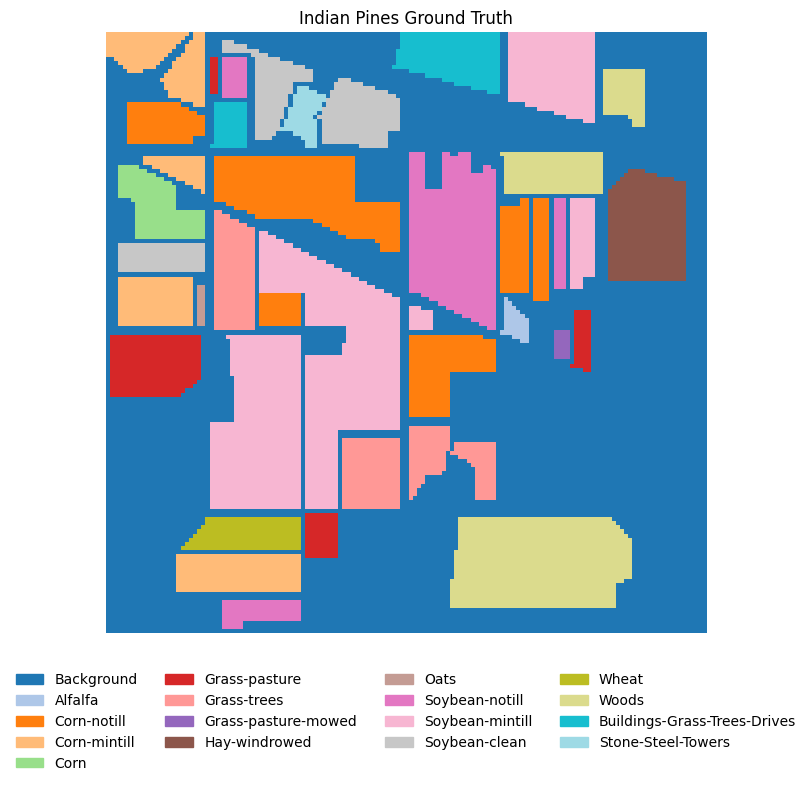

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

class_names = {
    0: "Background",
    1: "Alfalfa",
    2: "Corn-notill",
    3: "Corn-mintill",
    4: "Corn",
    5: "Grass-pasture",
    6: "Grass-trees",
    7: "Grass-pasture-mowed",
    8: "Hay-windrowed",
    9: "Oats",
    10: "Soybean-notill",
    11: "Soybean-mintill",
    12: "Soybean-clean",
    13: "Wheat",
    14: "Woods",
    15: "Buildings-Grass-Trees-Drives",
    16: "Stone-Steel-Towers"
}

plt.figure(figsize=(12, 8))
im = plt.imshow(labels, cmap='tab20', interpolation='none')
plt.title("Indian Pines Ground Truth")
plt.axis('off')

handles = [
    mpatches.Patch(color=im.cmap(im.norm(cls)), label=name)
    for cls, name in class_names.items()
    if cls in np.unique(labels)
]

plt.legend(
    handles=handles,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=4,
    frameon=False
)

plt.tight_layout()
plt.show()


### 3. Вибір гіперпараметрів

In [ ]:
# ADR
num_bands = 12
lam = 0.3
n_bins = 256 # number of intervals for descratization of continues data. Higher number improves comp accuracy
bandesSelectionMethod = 'MADR' # modified ADR

# CNN
train_split = 0.3 # T
batch_size = 256
learning_rate = 2e-2
epochs = 150

patch_size = 25


### 4. Адаптивне зменшення розмірності

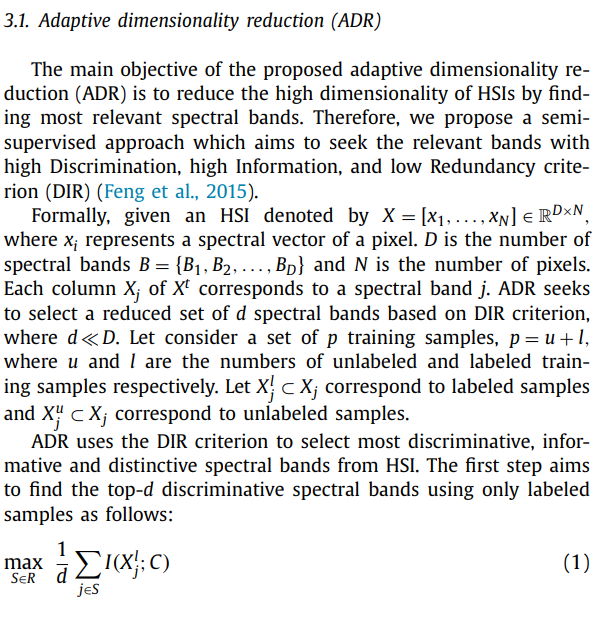

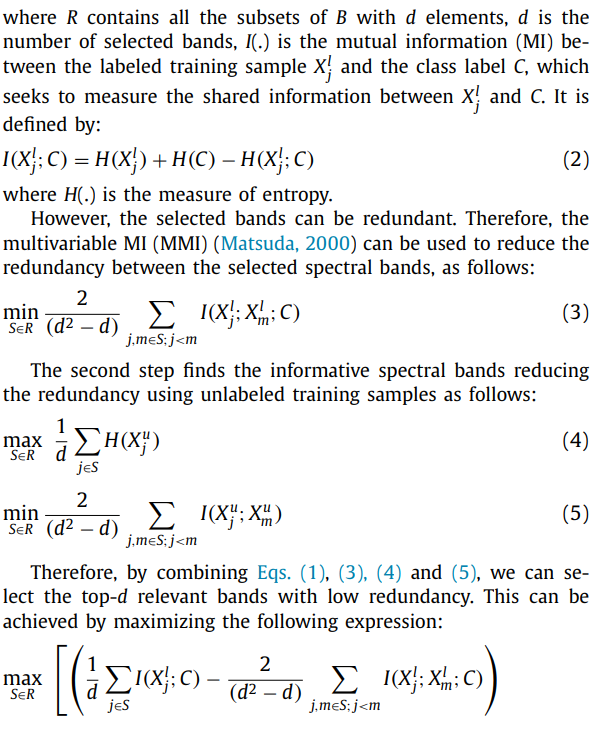

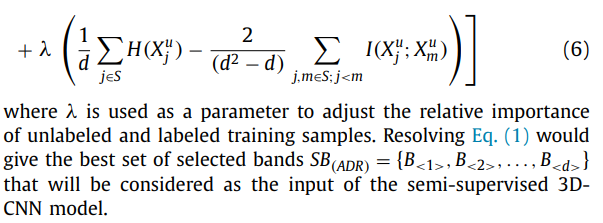

In [10]:
from src.ADR import adaptive_band_selection

# for n_bins = 20
# bestBandes = [102, 103, 104, 105, 106, 107, 109, 111, 143, 144, 145, 198] # score: -0.4564230215680064

# for n_bins = 40
# bestBandes = [1, 2, 3, 4, 103, 104, 105, 106, 143, 144, 145, 164] # score: -0.3543726783880011

# for n_bins = 100
# bestBandes = [0, 1, 2, 3, 4, 5, 143, 144, 145, 163, 198, 199] # score: -0.31792467094986165

# for n_bins = 256
# bestBandes = [1, 3, 4, 103, 104, 143, 144, 145, 181, 197, 198, 199] # score: -0.6305775246332581

# best according to paper
# bestBandes = [7, 17, 26, 42, 59, 86, 121, 147, 165, 181, 193, 205] # score: -0.5587357010503934

bestBandes_adr = adaptive_band_selection(data, labels, num_bands=num_bands, lam=lam, n_bins=n_bins)

(21025, 200)
[0.3097166  0.01012146 0.57034413 0.09564777 0.09412955 0.00759109]
[ 61.   2. 114.  19.  18.   1.]
Mutual Information between bands and labels
band 0: 0.580398174902564
band 50: 0.6341427488312277
band 100: 0.6251155726132356
band 150: 0.8918445187633418

Unlabled bands entropy
band 0: 5.0213200653774726
band 50: 6.736394282746895
band 100: 5.94617727459124
band 150: 6.486559196690928



Band selection:  42%|████▏     | 5/12 [00:33<01:06,  9.57s/it]/home/yaroslavp/workspace/master_IASA/master_thesis/.venv/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_label = type_of_target(labels_true)
/home/yaroslavp/workspace/master_IASA/master_thesis/.venv/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_label = type_of_target(labels_true)
Band selection:  50%|█████     | 6/12 [00:58<01:28, 14.67s/it]/home/yaroslavp/workspace/master_IASA/master_thesis/.venv/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_label = type_of_target(labels_true)
/home/yaroslavp/workspace/master_IASA/master_thesis/.venv/lib/python3.12/site-packages/sklear

Final score: 0.9206369589432482

Score comps mean ratio (%)
 rel: 22
 disred: 24
 lam * div: 46.288194
 lam * redun: 7.200615


In [11]:
print('Best bandes score ordered by desc:', bestBandes_adr)

Best bandes score ordered by desc: [111, 110, 4, 108, 109, 112, 107, 5, 8, 10, 113, 7]


In [12]:
sorted(bestBandes_adr)

[4, 5, 7, 8, 10, 107, 108, 109, 110, 111, 112, 113]

In [13]:
# Check ARD score of a bandes list

#adaptive_band_selection(data, labels, num_bands=num_bands, lam=lam, n_bins=n_bins, onlyScore=[102, 103, 104, 105, 106, 107, 109, 111, 143, 144, 145, 198])

Best bandes (ADR)


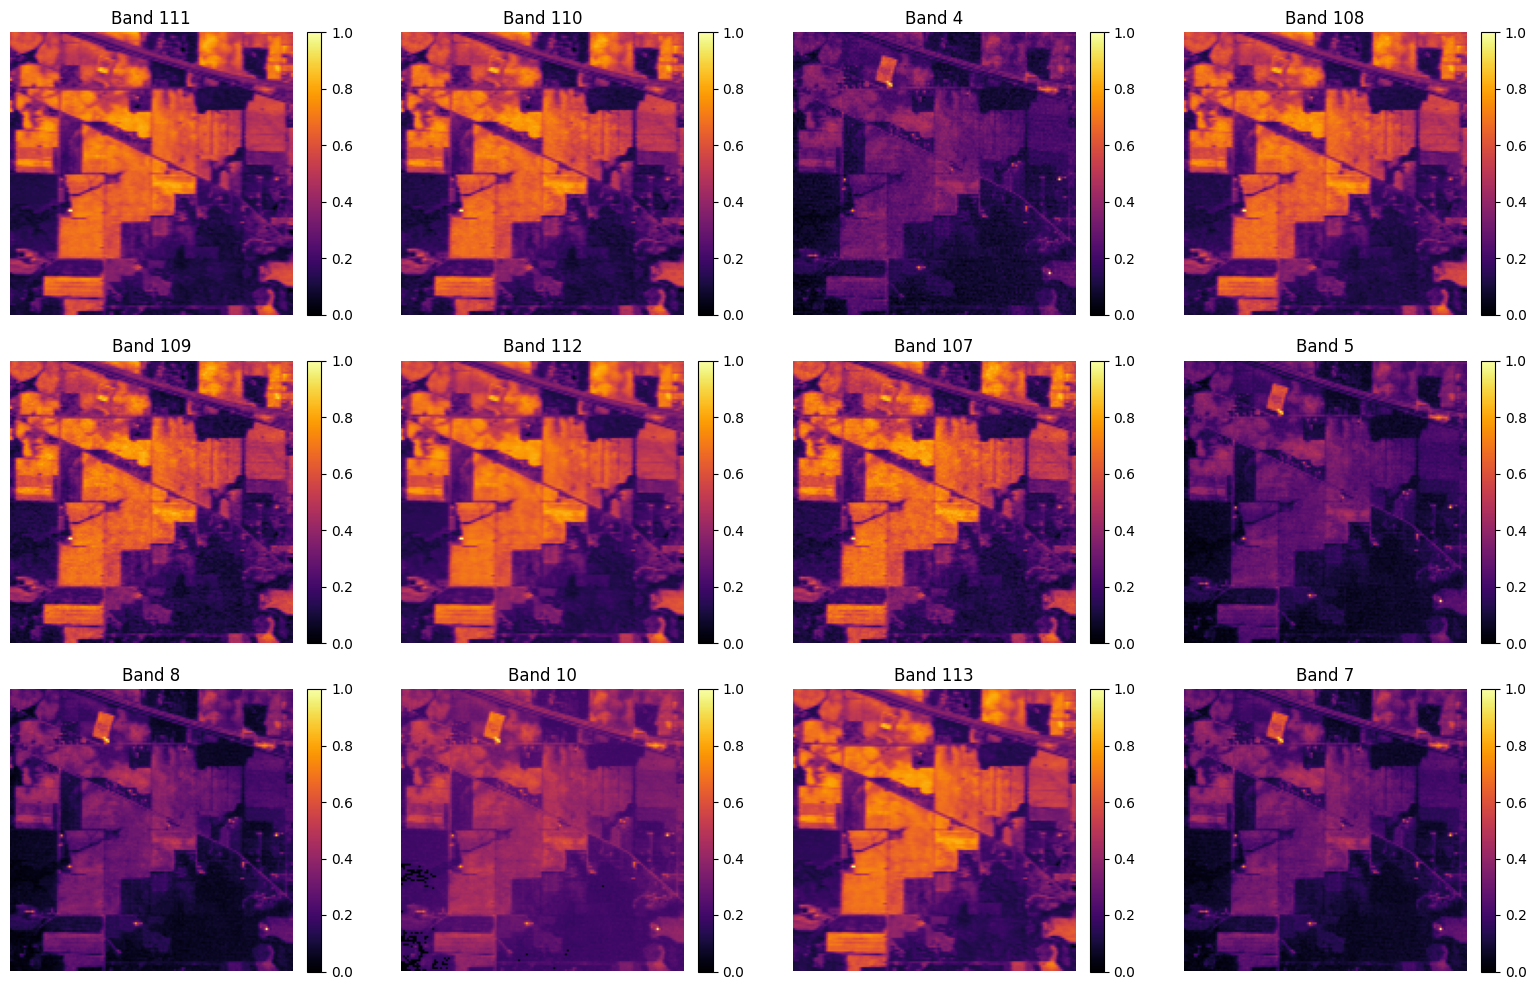

In [14]:
import math
import matplotlib.pyplot as plt


def largest_factor_pair(n):
    for i in range(int(math.sqrt(n)), 0, -1):
        if n % i == 0:
            return i, n // i
rows, columns = largest_factor_pair(num_bands)

print('Best bandes (ADR)')
fig, axes = plt.subplots(rows, columns, figsize=(16, 10))
axes = axes.flatten()

for i, band in enumerate(bestBandes_adr):
    ax = axes[i]
    im = ax.imshow(data[:, :, band], cmap='inferno')
    ax.set_title(f'Band {band}')
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [15]:
from sklearn.preprocessing import KBinsDiscretizer


def compute_entropy(x, n_bins):
    """Estimate entropy using histogram bins."""
    hist, _ = np.histogram(x, bins=n_bins, density=True)
    hist = hist[hist > 0]
    return -np.sum(hist * np.log2(hist))

print('Choosed bandes\' entropy')
for i, band in enumerate(bestBandes_adr):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    img = data[:, :, band]
    img_disc = discretizer.fit_transform(img)
    entropy = compute_entropy(img_disc, n_bins)
    print('Band', band, '=', entropy)

Choosed bandes' entropy
Band 111 = 7.527374000247207
Band 110 = 7.5285303112783115
Band 4 = 7.4200799751752795
Band 108 = 7.509579327702765
Band 109 = 7.539591537628809
Band 112 = 7.538584373248469
Band 107 = 7.5068586268246476
Band 5 = 7.399947173625609
Band 8 = 7.429572386409388
Band 10 = 7.520469968178082
Band 113 = 7.5438246957035044
Band 7 = 7.429177334134233


### Модифікована ADR

In [16]:
bestBandes_adrm = adaptive_band_selection(data, labels, num_bands=num_bands, lam=lam, n_bins=n_bins, 
                                       modified=True)

(21025, 200)
[0.3097166  0.01012146 0.57034413 0.09564777 0.09412955 0.00759109]
[ 61.   2. 114.  19.  18.   1.]
Mutual Information between bands and labels
band 0: 0.580398174902564
band 50: 0.6341427488312277
band 100: 0.6251155726132356
band 150: 0.8918445187633418

Unlabled bands entropy
band 0: 5.0213200653774726
band 50: 6.736394282746895
band 100: 5.94617727459124
band 150: 6.486559196690928



Band selection:  58%|█████▊    | 7/12 [01:52<01:20, 16.11s/it]


KeyboardInterrupt: 

Best bandes (ADRM)


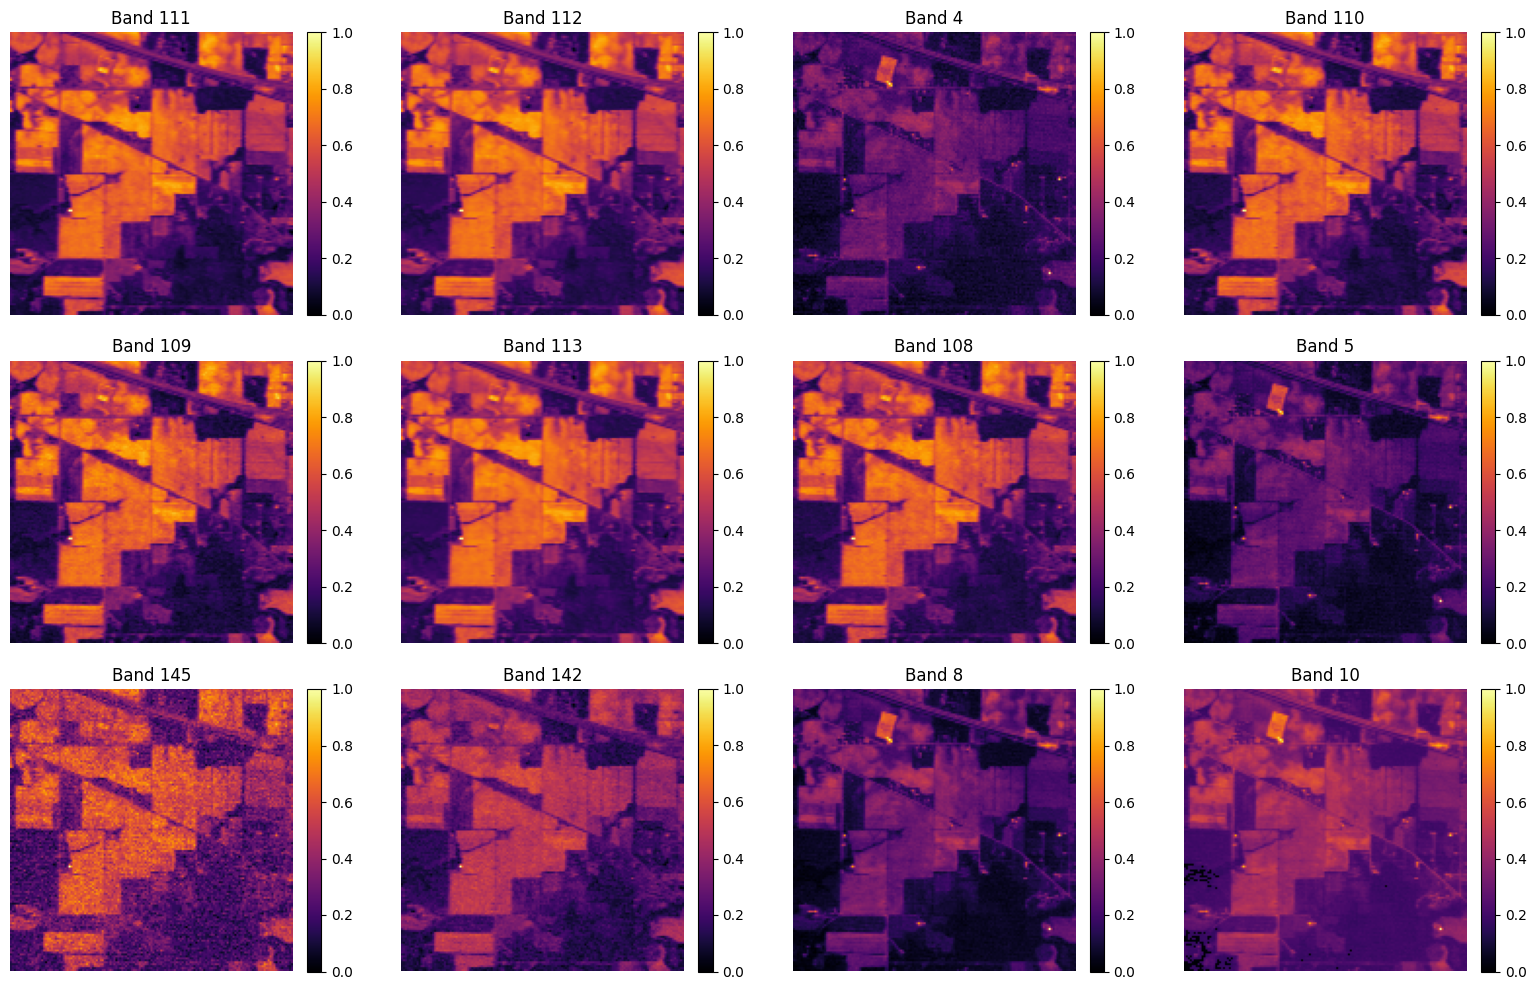

In [ ]:
import math
import matplotlib.pyplot as plt


def largest_factor_pair(n):
    for i in range(int(math.sqrt(n)), 0, -1):
        if n % i == 0:
            return i, n // i
rows, columns = largest_factor_pair(num_bands)

print('Best bandes (MADR)')
fig, axes = plt.subplots(rows, columns, figsize=(16, 10))
axes = axes.flatten()

for i, band in enumerate(bestBandes_adrm):
    ax = axes[i]
    im = ax.imshow(data[:, :, band], cmap='inferno')
    ax.set_title(f'Band {band}')
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [ ]:
if bandesSelectionMethod == 'MADR':
    bestBandes = bestBandes_adrm
else:
    bestBandes = bestBandes_adr

In [ ]:
data_adr = data[:,:, bestBandes]

### 5. Розбиття датасету на блоки

In [ ]:
from sklearn.preprocessing import StandardScaler

def normalize_patch(patch):
    h, w, b = patch.shape
    flat = patch.reshape(-1, b)  # shape (H*W, B)
    scaled = StandardScaler().fit_transform(flat)
    return scaled.reshape(h, w, b)

def extract_3d_patches(data, labels, patch_size=25, samples_per_class=20):
    pad = patch_size // 2
    data_padded = np.pad(data, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
    h, w, b = data.shape
    patches, targets = [], []
    for cls in np.unique(labels):
        coords = np.argwhere(labels == cls)
        np.random.shuffle(coords)
        for (y, x) in coords[:samples_per_class]:
            patch = data_padded[y:y+patch_size, x:x+patch_size, :]
            patch = normalize_patch(patch)

            patches.append(patch)
            targets.append(cls)
    patches = np.array(patches)
    patches = patches[:, np.newaxis, :, :, :] # Add dummy channel = 1
    patches = np.transpose(patches, (0, 1, 4, 2, 3))  # (N, 1, Bands, H, W)
    return torch.tensor(patches, dtype=torch.float32), torch.tensor(targets)

X, y = extract_3d_patches(data_adr, labels, patch_size, samples_per_class=-1)

In [ ]:
X.shape

torch.Size([21008, 1, 12, 25, 25])

In [ ]:
y.shape

torch.Size([21008])

In [ ]:
mask_labeled = y > 0
X_labeled = X[mask_labeled]
y_labeled = y[mask_labeled] - 1  # zero-based
X_unlabeled = X[~mask_labeled]

In [ ]:
X_labeled.shape

torch.Size([10233, 1, 12, 25, 25])

In [ ]:
X_unlabeled.shape

torch.Size([10775, 1, 12, 25, 25])

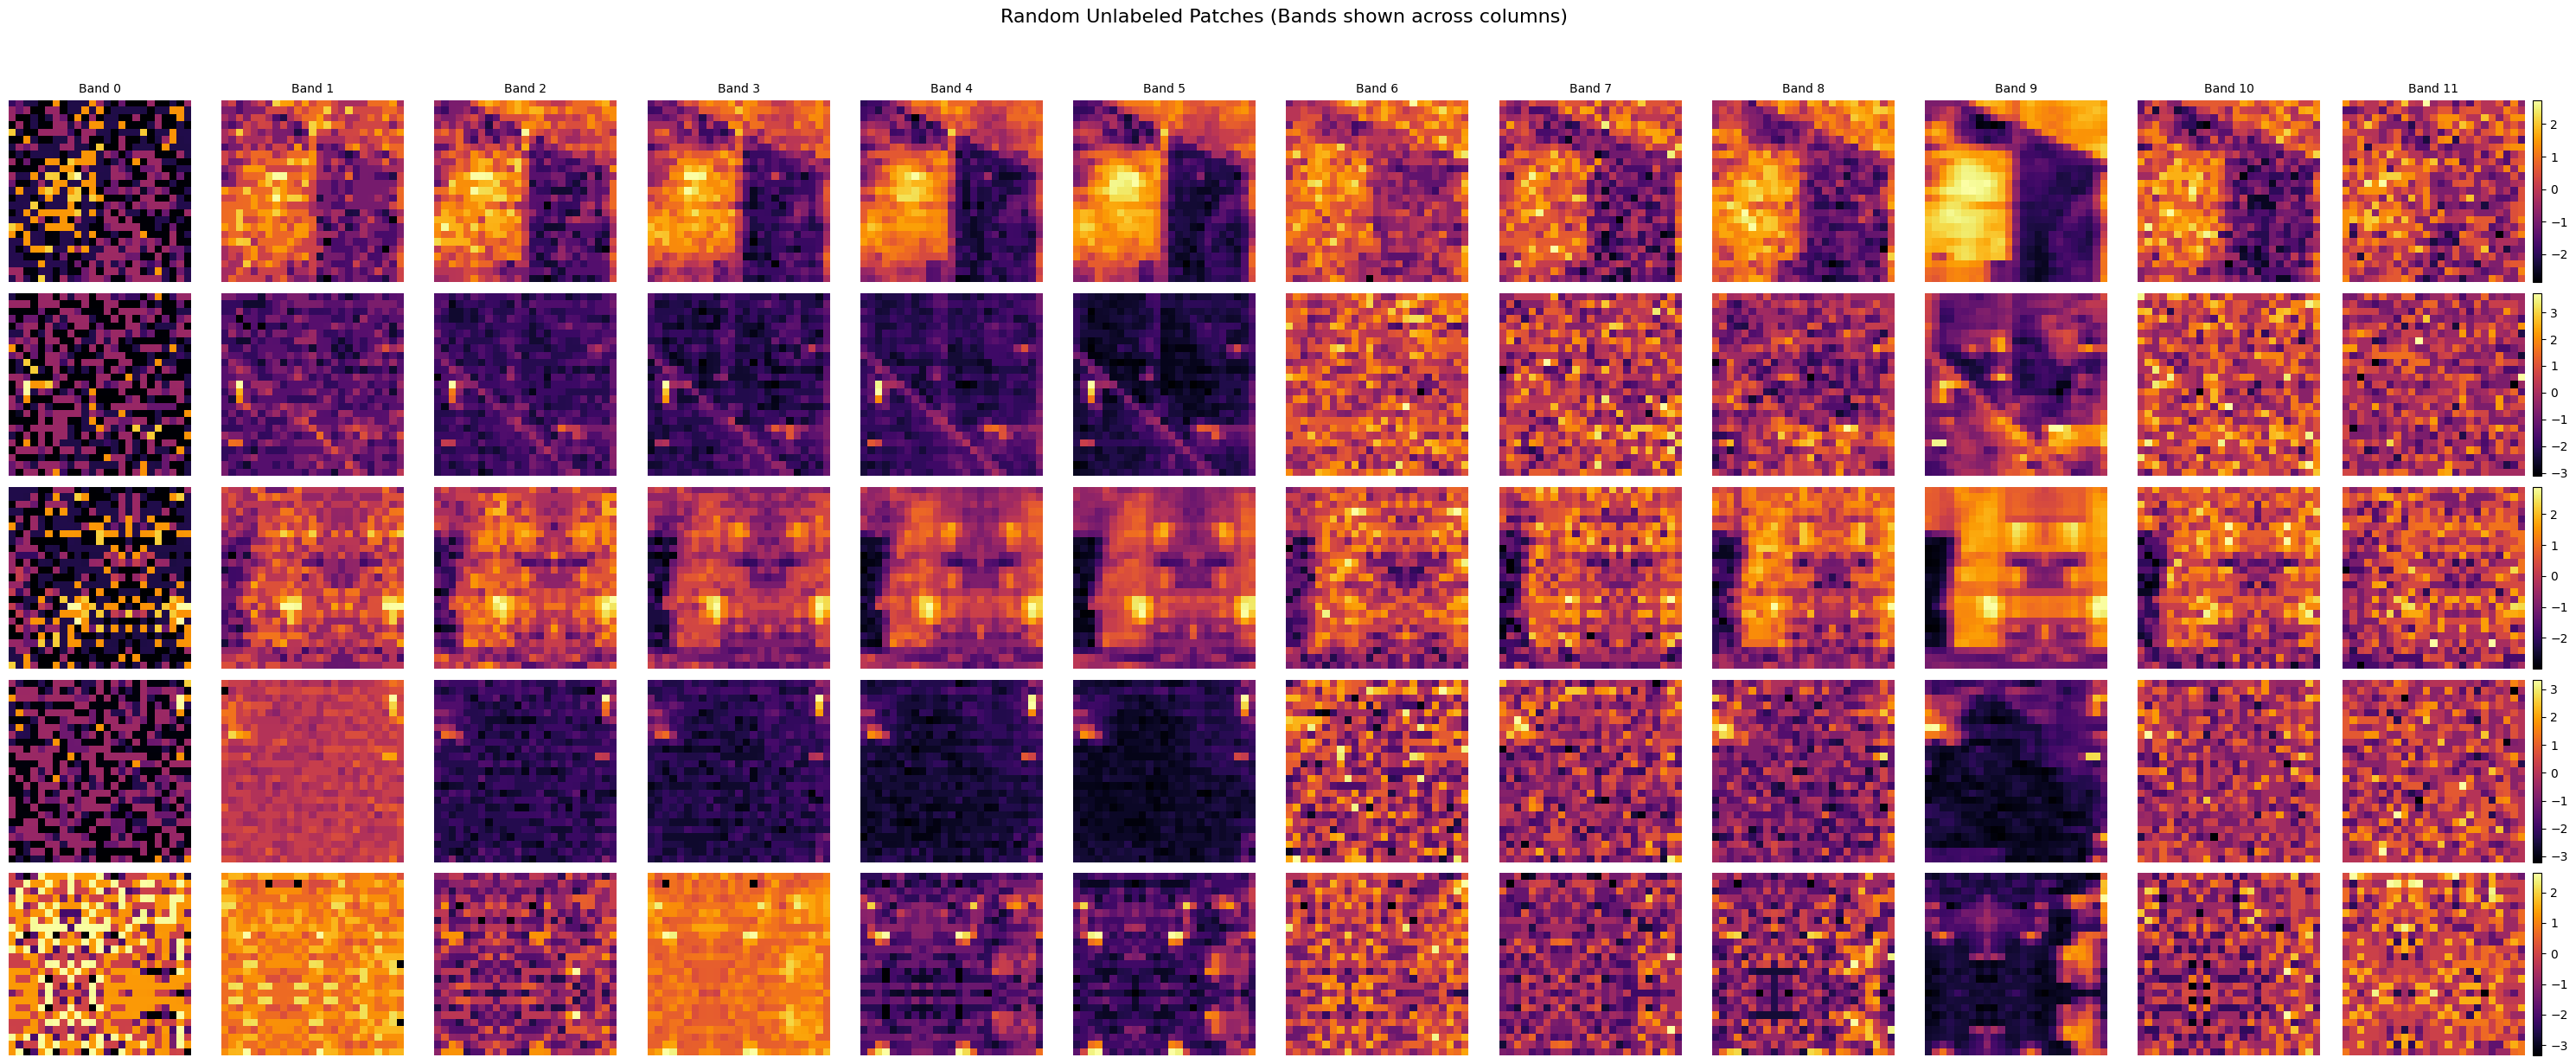

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

patches_to_print = 5

rng = np.random.default_rng(12345)
patch_n = rng.integers(low=0, high=len(X_unlabeled), size=patches_to_print)

fig, axes = plt.subplots(patches_to_print, num_bands, figsize=(num_bands * 2.5, patches_to_print * 2.5))

for i, p in enumerate(patch_n):
    for j in range(num_bands):
        ax = axes[i][j]
        im = ax.imshow(X_unlabeled[p, 0, j, :, :], cmap='inferno')
        ax.axis('off')

        print(f"p={p}, b={j}: ")

        # Column title: band number (only for top row)
        if i == 0:
            ax.set_title(f'Band {j}', fontsize=10)

        # Optional: colorbar on last column only
        if j == num_bands - 1:
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            
fig.suptitle('Random Unlabeled Patches (Bands shown across columns)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader


import kornia.augmentation as K
import torch.nn as nn

class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, device='cuda'):
        self.X = X  # shape: [N, 1, Bands, H, W]
        self.y = y
        self.device = device

        self.augment = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            K.RandomVerticalFlip(p=0.5),
            # K.RandomAffine(degrees=15, translate=0.1, scale=(0.9, 1.1), p=0.5),
            K.RandomGaussianNoise(mean=0.0, std=0.05, p=0.3)
        ).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # input shape: [1, Bands, H, W]
        x = self.X[idx].squeeze(0).to(self.device)  # now shape: [Bands, H, W]
        y = self.y[idx]

        x = x.squeeze(0)          # x: [Bands, H, W]
        x = x.unsqueeze(0)        # x: [1, Bands, H, W] (batch size = 1)
        x_aug = self.augment(x)
        return x_aug, y

X_labeled, X_val, y_labeled, y_val = train_test_split(X_labeled, y_labeled, test_size=1-train_split, random_state=42, stratify=y_labeled)

labeled_set = AugmentedDataset(X_labeled, y_labeled)
val_set = TensorDataset(X_val, y_val)
unlabled_set = TensorDataset(X_unlabeled)

labeled_loader = DataLoader(labeled_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
unlabled_loader = DataLoader(unlabled_set, batch_size=batch_size, shuffle=True)

In [ ]:
X_labeled.shape

torch.Size([3069, 1, 12, 25, 25])

### 6. Згорткова мережа

In [ ]:
import wandb
import os

# os.environ["WANDB_MODE"] = "offline"

model_name = "3dcnn-indian-pines-patches-MADR"
wandb.init(
    project="semi-supervised-hsi",
    entity="oypio-kpi", 
    name=model_name,
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "lr": learning_rate,
        "model": "3D CNN",
        "architecture": "semi-supervised",
        "bandesSelectionMethod": bandesSelectionMethod,
        "bestBandes": bestBandes
    }
)

wandb: Currently logged in as: oypio (oypio-kpi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
from src.CNN import SemiSupervised3DCNN
from torch.optim.lr_scheduler import LambdaLR

def linear_warmup_cosine_decay(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

model = SemiSupervised3DCNN(in_channels=1, num_classes=len(class_names) - 1)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = linear_warmup_cosine_decay(optimizer, warmup_epochs=10, total_epochs=epochs)

model

SemiSupervised3DCNN(
  (encoder): Encoder3D(
    (conv1): Conv3d(1, 128, kernel_size=(3, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(128, 192, kernel_size=(3, 5, 5), stride=(1, 1, 1), padding=(1, 2, 2))
    (bn2): BatchNorm3d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv3d(192, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder3D(
    (deconv1): ConvTranspose3d(256, 192, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (deconv2): ConvTranspose3d(192, 128, kernel_size=(3, 5, 5), stride=(1, 1, 1), paddi

In [ ]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, r2_score, mean_squared_error, mean_absolute_percentage_error

def compute_cls_metrics(y_true, y_pred, num_classes, val_loss):
    oa = accuracy_score(y_true, y_pred)

    conf_mat = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    per_class_acc = np.diag(conf_mat) / conf_mat.sum(axis=1)
    aa = np.mean(per_class_acc)

    kappa = cohen_kappa_score(y_true, y_pred)

    return {
        "Ov_acc": oa,
        "Av_acc": aa,
        "Kappa": kappa,
        "val_loss": val_loss
    }

def compute_rec_metrics(y_true, y_pred, val_loss):
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()

    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        "r2": r2,
        "mse": mse,
        "mape": mape,
        "val_loss": val_loss
    }

In [ ]:
import torch.nn as nn

def validate_cls(model, val_loader, criterion):
    model.eval()
    correct, total = 0, 0
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            logits = model(x_val)
            loss = criterion(logits, y_val)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y_val).sum().item()
            total += y_val.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_val.cpu().numpy())
    
    return compute_cls_metrics(all_labels, all_preds, model.classifier.num_classes, val_loss)

def validate_rec(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_val, _ in val_loader:
            x_val = x_val.to(device)
            optimizer.zero_grad()
            preds = model(x_val, mode='reconstruct')
            loss = criterion(preds, x_val)
            val_loss += loss.item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(x_val.cpu().numpy())
    
    return compute_rec_metrics(all_labels, all_preds, val_loss)


def train_semi_supervised(model, optimizer, scheduler, lam, labeled_loader, unlabeled_loader, val_loader, epochs=20):
    model.to(device)
    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()
    cls_loss = ce_loss
    rec_loss = lambda pred, target: lam * mse_loss(pred, target)
    best_val_acc = 0.0

    for epoch in range(epochs):
        validate = True if epoch >= epochs * 0.0 else False
        
        cls_loss_sum, rec_loss_sum = 0.0, 0.0

        # ----------- Labeled (supervised) step -----------
        model.train()
        for x_l, y_l in labeled_loader:
            x_l, y_l = x_l.to(device), y_l.to(device)
            optimizer.zero_grad()
            logits = model(x_l)
            loss = cls_loss(logits, y_l)
            loss.backward()
            optimizer.step()
            cls_loss_sum += loss.item()
        
        if validate:
            cls_metrics_bef_rec = validate_cls(model, val_loader, cls_loss)

        # ----------- Unlabeled (reconstruction) step -----------
        model.train()
        for x_u, in unlabeled_loader:
            x_u = x_u.to(device)
            optimizer.zero_grad()
            recon = model(x_u, mode='reconstruct')
            loss = rec_loss(recon, x_u)
            loss.backward()
            optimizer.step()
            rec_loss_sum += loss.item()

        if validate:
            cls_metrics = validate_cls(model, val_loader, cls_loss)
            rec_metrcis = validate_rec(model, val_loader, rec_loss)
            cls_metrics_gain_aft_rec = {k: v - cls_metrics_bef_rec[k] for k,v in  cls_metrics.items()}



            val_acc = cls_metrics["Ov_acc"]

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                model_dir = f"models/{model_name}"
                os.makedirs(model_dir, exist_ok=True)
                torch.save(model.state_dict(), model_dir+"/best_model.pth")
            
            logs = {
                "epoch": epoch + 1,
                "cls_train_loss": cls_loss_sum,
                "cls_val_loss": cls_metrics['val_loss'],
                "cls_val_acc": cls_metrics["Ov_acc"],
                "cls_val_average_acc": cls_metrics["Av_acc"],
                "cls_val_kappa": cls_metrics["Kappa"],
                
                "rec_train_loss": rec_loss_sum,
                "rec_val_r2": rec_metrcis['r2'],
                "rec_val_mse": rec_metrcis['mse'],
                "rec_val_mape": rec_metrcis['mape'],
                "rec_val_loss": rec_metrcis['val_loss'],

                "cls_gain_aft_rec_val_loss": cls_metrics_gain_aft_rec['val_loss'],
                "cls_gain_aft_rec_val_acc": cls_metrics_gain_aft_rec["Ov_acc"],
                "cls_gain_aft_rec_val_average_acc": cls_metrics_gain_aft_rec["Av_acc"],
                "cls_gain_aft_rec_val_kappa": cls_metrics_gain_aft_rec["Kappa"],
            }
        else:
            logs = {
                "epoch": epoch + 1,
                "cls_train_loss": cls_loss_sum,
                "rec_train_loss": rec_loss_sum
            }

        print(', '.join([f"{k} = {v:.4f}" for k,v in logs.items()]))
        wandb.log(logs)

        scheduler.step()



train_semi_supervised(model, optimizer, scheduler, lam, labeled_loader, unlabled_loader, val_loader, epochs)

artifact = wandb.Artifact(f"best-{model_name}", type="model")
artifact.add_file(f"models/{model_name}/best_model.pth")
wandb.log_artifact(artifact)

epoch = 1.0000, cls_train_loss = 25.0964, cls_val_loss = 56.1843, cls_val_acc = 0.3312, cls_val_average_acc = 0.1077, cls_val_kappa = 0.1517, rec_train_loss = 11.6884, rec_val_r2 = 0.1435, rec_val_mse = 0.8565, rec_val_mape = 2978453760.0000, rec_val_loss = 7.1946, cls_gain_aft_rec_val_loss = -14.7162, cls_gain_aft_rec_val_acc = 0.0782, cls_gain_aft_rec_val_average_acc = -0.0118, cls_gain_aft_rec_val_kappa = 0.0134
epoch = 2.0000, cls_train_loss = 19.7476, cls_val_loss = 58.6424, cls_val_acc = 0.3212, cls_val_average_acc = 0.1091, cls_val_kappa = 0.1499, rec_train_loss = 10.6610, rec_val_r2 = 0.1862, rec_val_mse = 0.8138, rec_val_mape = 4074536448.0000, rec_val_loss = 6.8362, cls_gain_aft_rec_val_loss = 16.0133, cls_gain_aft_rec_val_acc = -0.1802, cls_gain_aft_rec_val_average_acc = -0.1868, cls_gain_aft_rec_val_kappa = -0.2605
epoch = 3.0000, cls_train_loss = 18.0332, cls_val_loss = 58.5872, cls_val_acc = 0.3202, cls_val_average_acc = 0.1192, cls_val_kappa = 0.1665, rec_train_loss = 10

<Artifact best-3dcnn-indian-pines-patches-augmentAndNorm>

In [ ]:
wandb.finish()